# Natural Language Processing on Heat shock protein A4 related publications sourced from PubMed

In [468]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize
import medspacy
from transformers import pipeline
from datetime import datetime

## Step 1: Loading and cleaning the scraped Pubmed data

In [469]:
df = pd.read_csv("pubmed_scraped_data_hspa4.csv")
df.head()

,title,pmid,url,abstract
0,Tumor-educated B cells selectively promote breast cancer lymph node metastasis by HSPA4-targeting IgG,30643287,https://pubmed.ncbi.nlm.nih.gov/30643287,"Primary tumors may create the premetastatic niche in secondary organs for subsequent metastasis. Humoral immunity contributes to the progression of certain cancers, but the roles of B cells and their derived antibodies in premetastatic niche formation are poorly defined. Using a mouse model of spontaneous lymph node metastasis of breast cancer, we show that primary tumors induced B cell accumulation in draining lymph nodes. These B cells selectively promoted lymph node metastasis by producing pathogenic IgG that targeted glycosylated membrane protein HSPA4, and activated the HSPA4-binding protein ITGB5 and the downstream Src/NF-κB pathway in tumor cells for CXCR4/SDF1α-axis-mediated metastasis. High serum anti-HSPA4 IgG was correlated with high tumor HSPA4 expression and poor prognosis of breast cancer subjects. Our findings identify a key role for tumor-educated B cells and their derived antibodies in lymph node premetastatic niche formation, providing potential targets for cancer intervention."
1,HSPA4 upregulation induces immune evasion via ALKBH5/CD58 axis in gastric cancer,38589927,https://pubmed.ncbi.nlm.nih.gov/38589927,"Introduction:\n \n\n \n Gastric cancer (GC) is one of the leading causes of cancer-related death worldwide. Recently, targeted therapies including PD1 (programmed cell death 1) antibodies have been used in advanced GC patients. However, identifying new biomarker for immunotherapy is still urgently needed. The objective of this study is to unveil the immune evasion mechanism of GC cells and identify new biomarkers for immune checkpoint blockade therapy in patients with GC.\n \n\n\n\n\n\n Methods:\n \n\n \n Coimmunoprecipitation and meRIP were performed to investigate the mechanism of immune evasion of GC cells. Cocuture system was established to evaluate the cytotoxicity of cocultured CD8\n+\n T cells. The clinical significance of HSPA4 upregulation was analyzed by multiplex fluorescent immunohistochemistry staining in GC tumor tissues.\n \n\n\n\n\n\n Results:\n \n\n \n Histone acetylation causes HSPA4 upregulation in GC tumor tissues. HSPA4 upregulation increases the protein stability of m\n6\nA demethylase ALKBH5. ALKBH5 decreases CD58 in GC cells through m\n6\nA methylation regulation. The cytotoxicity of CD8\n+\n T cells are impaired and PD1/PDL1 axis is activated when CD8\n+\n T cells are cocultured with HSPA4 overexpressed GC cells. HSPA4 upregulation is associated with worse 5-year overall survival of GC patients receiving only surgery. It is an independent prognosis factor for worse survival of GC patients. In GC patients receiving the combined chemotherapy with anti-PD1 immunotherapy, HSPA4 upregulation is observed in responders compared with non-responders.\n \n\n\n\n\n\n Conclusion:\n \n\n \n HSPA4 upregulation causes the decrease of CD58 in GC cells via HSPA4/ALKBH5/CD58 axis, followed by PD1/PDL1 activation and impairment of CD8\n+\n T cell's cytotoxicity, finally induces immune evasion of GC cells. HSPA4 upregulation is associated with worse overall survival of GC patients with only surgery. Meanwhile, HSPA4 upregulation predicts for better response in GC patients receiving the combined immunotherapy."
2,HSPA4 Knockdown Retarded Progression and Development of Colorectal Cancer,34163243,https://pubmed.ncbi.nlm.nih.gov/34163243,"Purpose:\n \n\n \n Colorectal cancer (CRC) is a common malignancy associated with high morbidity and mortality. Heat shock 70 kDa protein 4 (HSPA4) has been shown to exert regulatory roles during tumor progression in different cancer types. Here, we investigated the expression and cellular functions of HSPA4 in CRC.\n \n\n\n\n\n\n Materials and methods:\n \n\n \n Expression of HSPA4 in CRC tissues and paracancerous tissues was analyzed by RT-qPCR and immunohistochemistry IHC staining. The fu

In [470]:
#check for missing values
df.isnull().sum()

title       0
pmid        0
url         0
abstract    2
dtype: int64

In [471]:
df.dropna(inplace=True) # Drop missing values

#check for missing values
df.isnull().sum()

title       0
pmid        0
url         0
abstract    0
dtype: int64

In [472]:
df['abstract'] = df['abstract'].astype(str) # Convert abstract to string
df.head()

,title,pmid,url,abstract
0,Tumor-educated B cells selectively promote breast cancer lymph node metastasis by HSPA4-targeting IgG,30643287,https://pubmed.ncbi.nlm.nih.gov/30643287,"Primary tumors may create the premetastatic niche in secondary organs for subsequent metastasis. Humoral immunity contributes to the progression of certain cancers, but the roles of B cells and their derived antibodies in premetastatic niche formation are poorly defined. Using a mouse model of spontaneous lymph node metastasis of breast cancer, we show that primary tumors induced B cell accumulation in draining lymph nodes. These B cells selectively promoted lymph node metastasis by producing pathogenic IgG that targeted glycosylated membrane protein HSPA4, and activated the HSPA4-binding protein ITGB5 and the downstream Src/NF-κB pathway in tumor cells for CXCR4/SDF1α-axis-mediated metastasis. High serum anti-HSPA4 IgG was correlated with high tumor HSPA4 expression and poor prognosis of breast cancer subjects. Our findings identify a key role for tumor-educated B cells and their derived antibodies in lymph node premetastatic niche formation, providing potential targets for cancer intervention."
1,HSPA4 upregulation induces immune evasion via ALKBH5/CD58 axis in gastric cancer,38589927,https://pubmed.ncbi.nlm.nih.gov/38589927,"Introduction:\n \n\n \n Gastric cancer (GC) is one of the leading causes of cancer-related death worldwide. Recently, targeted therapies including PD1 (programmed cell death 1) antibodies have been used in advanced GC patients. However, identifying new biomarker for immunotherapy is still urgently needed. The objective of this study is to unveil the immune evasion mechanism of GC cells and identify new biomarkers for immune checkpoint blockade therapy in patients with GC.\n \n\n\n\n\n\n Methods:\n \n\n \n Coimmunoprecipitation and meRIP were performed to investigate the mechanism of immune evasion of GC cells. Cocuture system was established to evaluate the cytotoxicity of cocultured CD8\n+\n T cells. The clinical significance of HSPA4 upregulation was analyzed by multiplex fluorescent immunohistochemistry staining in GC tumor tissues.\n \n\n\n\n\n\n Results:\n \n\n \n Histone acetylation causes HSPA4 upregulation in GC tumor tissues. HSPA4 upregulation increases the protein stability of m\n6\nA demethylase ALKBH5. ALKBH5 decreases CD58 in GC cells through m\n6\nA methylation regulation. The cytotoxicity of CD8\n+\n T cells are impaired and PD1/PDL1 axis is activated when CD8\n+\n T cells are cocultured with HSPA4 overexpressed GC cells. HSPA4 upregulation is associated with worse 5-year overall survival of GC patients receiving only surgery. It is an independent prognosis factor for worse survival of GC patients. In GC patients receiving the combined chemotherapy with anti-PD1 immunotherapy, HSPA4 upregulation is observed in responders compared with non-responders.\n \n\n\n\n\n\n Conclusion:\n \n\n \n HSPA4 upregulation causes the decrease of CD58 in GC cells via HSPA4/ALKBH5/CD58 axis, followed by PD1/PDL1 activation and impairment of CD8\n+\n T cell's cytotoxicity, finally induces immune evasion of GC cells. HSPA4 upregulation is associated with worse overall survival of GC patients with only surgery. Meanwhile, HSPA4 upregulation predicts for better response in GC patients receiving the combined immunotherapy."
2,HSPA4 Knockdown Retarded Progression and Development of Colorectal Cancer,34163243,https://pubmed.ncbi.nlm.nih.gov/34163243,"Purpose:\n \n\n \n Colorectal cancer (CRC) is a common malignancy associated with high morbidity and mortality. Heat shock 70 kDa protein 4 (HSPA4) has been shown to exert regulatory roles during tumor progression in different cancer types. Here, we investigated the expression and cellular functions of HSPA4 in CRC.\n \n\n\n\n\n\n Materials and methods:\n \n\n \n Expression of HSPA4 in CRC tissues and paracancerous tissues was analyzed by RT-qPCR and immunohistochemistry IHC staining. The fu

## Step 2: Data Preprocessing

In [473]:
# Define a custom preprocessing component
def custom_preprocessor(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower()  # Lowercase
    text = re.sub(r'\n', '', text) # Remove newline character
    sentences = sent_tokenize(text)  # Sentence tokenization
    return sentences

In [474]:
# Apply preprocessing
df['Title_Sentences'] = df['title'].apply(custom_preprocessor)
df['Abstract_Sentences'] = df['abstract'].apply(custom_preprocessor)

# Combine sentences into a single list
df['Combined_Sentences'] = df.apply(lambda row: row['Title_Sentences'] + row['Abstract_Sentences'], axis=1)
# convert the list of sentences into a single string
df['Combined_Sentences'] = df['Combined_Sentences'].apply(lambda x: ' '.join(x))

df.head()

,title,pmid,url,abstract,Title_Sentences,Abstract_Sentences,Combined_Sentences
0,Tumor-educated B cells selectively promote breast cancer lymph node metastasis by HSPA4-targeting IgG,30643287,https://pubmed.ncbi.nlm.nih.gov/30643287,"Primary tumors may create the premetastatic niche in secondary organs for subsequent metastasis. Humoral immunity contributes to the progression of certain cancers, but the roles of B cells and their derived antibodies in premetastatic niche formation are poorly defined. Using a mouse model of spontaneous lymph node metastasis of breast cancer, we show that primary tumors induced B cell accumulation in draining lymph nodes. These B cells selectively promoted lymph node metastasis by producing pathogenic IgG that targeted glycosylated membrane protein HSPA4, and activated the HSPA4-binding protein ITGB5 and the downstream Src/NF-κB pathway in tumor cells for CXCR4/SDF1α-axis-mediated metastasis. High serum anti-HSPA4 IgG was correlated with high tumor HSPA4 expression and poor prognosis of breast cancer subjects. Our findings identify a key role for tumor-educated B cells and their derived antibodies in lymph node premetastatic niche formation, providing potential targets for cancer intervention.",[tumoreducated b cells selectively promote breast cancer lymph node metastasis by hspa4targeting igg],[primary tumors may create the premetastatic niche in secondary organs for subsequent metastasis humoral immunity contributes to the progression of certain cancers but the roles of b cells and their derived antibodies in premetastatic niche formation are poorly defined using a mouse model of spontaneous lymph node metastasis of breast cancer we show that primary tumors induced b cell accumulation in draining lymph nodes these b cells selectively promoted lymph node metastasis by producing pathogenic igg that targeted glycosylated membrane protein hspa4 and activated the hspa4binding protein itgb5 and the downstream srcnfb pathway in tumor cells for cxcr4sdf1axismediated metastasis high serum antihspa4 igg was correlated with high tumor hspa4 expression and poor prognosis of breast cancer subjects our findings identify a key role for tumoreducated b cells and their derived antibodies in lymph node premetastatic niche formation providing potential targets for cancer intervention],tumoreducated b cells selectively promote breast cancer lymph node metastasis by hspa4targeting igg primary tumors may create the premetastatic niche in secondary organs for subsequent metastasis humoral immunity contributes to the progression of certain cancers but the roles of b cells and their derived antibodies in premetastatic niche formation are poorly defined using a mouse model of spontaneous lymph node metastasis of breast cancer we show that primary tumors induced b cell accumulation in draining lymph nodes these b cells selectively promoted lymph node metastasis by producing pathogenic igg that targeted glycosylated membrane protein hspa4 and activated the hspa4binding protein itgb5 and the downstream srcnfb pathway in tumor cells for cxcr4sdf1axismediated metastasis high serum antihspa4 igg was correlated with high tumor hspa4 expression and poor prognosis of breast cancer subjects our findings identify a key role for tumoreducated b cells and their derived antibodies in lymph node premetastatic niche formation providing potential targets for cancer intervention
1,HSPA4 upregulation induces immune evasion via ALKBH5/CD58 axis in gastric cancer,38589927,https://pubmed.ncbi.nlm.nih.gov/38589927,"Introduction:\n \n\n \n Gastric cancer (GC) is one of the leading causes of cancer-related death worldwide. Recently, targeted therapies including PD1 (programmed cell death 1) antibodies have been used in advanced GC patients. However, identifying new biomarker for immunotherapy is still urgently needed. The objective of this study is to unveil the immune evasion mechanism of GC cells and identify new biomarkers for immune checkp

## Step 3: Zero-Shot Classification

### Setup the transformer and define labels

In [475]:
# Load the zero-shot classification pipeline
classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')

# Define candidate labels to classify the text
candidate_labels = ["ubiquitination", "HSC70", "proteasome", "cardiac hypertrophy", "cancer", "apoptosis", "autophagy", "nucleotide exchange factor", "P62/SQSTM1", "LC3"]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


### Classify each sentence for labels related to chaperones and cellular health

In [476]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Sentence', 'Labels', 'Scores'])

# Loop through each sentence in the DataFrame and classify it
for sentence in df['Combined_Sentences'].tolist():
    # Perform zero-shot classification
    classification_result = classifier(sentence, candidate_labels)
    
    # Extract classification results
    labels = classification_result['labels']
    scores = classification_result['scores']
    
    # Print the classification result
    print(f"Sentence: {sentence[:150]}")
    print(f"Classification Result: {labels}")
    print(f"Scores: {scores}")
    print()
    
    # Create a temporary DataFrame for this sentence
    temp_df = pd.DataFrame({'Sentence': [sentence], 'Labels': [labels], 'Scores': [scores]})
    
    # Append the result to the results_df DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

Sentence: tumoreducated b cells selectively promote breast cancer lymph node metastasis by hspa4targeting igg primary tumors may create the premetastatic niche 
Classification Result: ['cancer', 'LC3', 'HSC70', 'P62/SQSTM1', 'proteasome', 'ubiquitination', 'nucleotide exchange factor', 'autophagy', 'apoptosis', 'cardiac hypertrophy']
Scores: [0.6762353181838989, 0.10858528316020966, 0.050915852189064026, 0.033793073147535324, 0.03292522951960564, 0.02974163554608822, 0.023961974307894707, 0.02216721512377262, 0.013303634710609913, 0.008370772935450077]

Sentence: hspa4 upregulation induces immune evasion via alkbh5cd58 axis in gastric cancer introduction                    gastric cancer gc is one of the leadin
Classification Result: ['cancer', 'LC3', 'proteasome', 'P62/SQSTM1', 'nucleotide exchange factor', 'ubiquitination', 'autophagy', 'HSC70', 'apoptosis', 'cardiac hypertrophy']
Scores: [0.8288431763648987, 0.028598923236131668, 0.026072241365909576, 0.022245757281780243, 0.0202091

### Saving the current results

In [477]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# save the results to a CSV file with the current time stamp
filename = f"zero_shot_classification_results_{current_time}.csv"
results_df.to_csv(filename, index=False)

## Step 4: Data Visualization

In [446]:
#load the results
#results_df = pd.read_csv('zero_shot_classification_results_2024-07-22_16-20-46.csv')
results_df.head()

,Sentence,Labels,Scores
0,tumoreducated b cells selectively promote breast cancer lymph node metastasis by hspa4targeting igg primary tumors may create the premetastatic niche in secondary organs for subsequent metastasis humoral immunity contributes to the progression of certain cancers but the roles of b cells and their derived antibodies in premetastatic niche formation are poorly defined using a mouse model of spontaneous lymph node metastasis of breast cancer we show that primary tumors induced b cell accumulation in draining lymph nodes these b cells selectively promoted lymph node metastasis by producing pathogenic igg that targeted glycosylated membrane protein hspa4 and activated the hspa4binding protein itgb5 and the downstream srcnfb pathway in tumor cells for cxcr4sdf1axismediated metastasis high serum antihspa4 igg was correlated with high tumor hspa4 expression and poor prognosis of breast cancer subjects our findings identify a key role for tumoreducated b cells and their derived antibodies in lymph node premetastatic niche formation providing potential targets for cancer intervention,"['cancer', 'LC3', 'HSC70', 'P62/SQSTM1', 'proteasome', 'ubiquitination', 'nucleotide exchange factor', 'autophagy', 'apoptosis', 'cardiac hypertrophy']","[0.6762353181838989, 0.10858528316020966, 0.050915852189064026, 0.033793073147535324, 0.03292522951960564, 0.02974163554608822, 0.023961974307894707, 0.02216721512377262, 0.013303634710609913, 0.008370772935450077]"
1,hspa4 upregulation induces immune evasion via alkbh5cd58 axis in gastric cancer introduction gastric cancer gc is one of the leading causes of cancerrelated death worldwide recently targeted therapies including pd1 programmed cell death 1 antibodies have been used in advanced gc patients however identifying new biomarker for immunotherapy is still urgently needed the objective of this study is to unveil the immune evasion mechanism of gc cells and identify new biomarkers for immune checkpoint blockade therapy in patients with gc methods coimmunoprecipitation and merip were performed to investigate the mechanism of immune evasion of gc cells cocuture system was established to evaluate the cytotoxicity of cocultured cd8 t cells the clinical significance of hspa4 upregulation was analyzed by multiplex fluorescent immunohistochemistry staining in gc tumor tissues results histone acetylation causes hspa4 upregulation in gc tumor tissues hspa4 upregulation increases the protein stability of m6a demethylase alkbh5 alkbh5 decreases cd58 in gc cells through m6a methylation regulation the cytotoxicity of cd8 t cells are impaired and pd1pdl1 axis is activated when cd8 t cells are cocultured with hspa4 overexpressed gc cells hspa4 upregulation is associated with worse 5year overall survival of gc patients receiving only surgery it is an independent prognosis factor for worse survival of gc patients in gc patients receiving the combined chemotherapy with antipd1 immunotherapy hspa4 upregulation is observed in responders compared with nonresponders conclusion hspa4 upregulation causes the decrease of cd58 in gc cells via hspa4alkbh5cd58 axis followed by pd1pdl1 activation and impairment of cd8 t cells cytotoxicity finally induces immune evasion of gc cells hspa4 upregulation is associated with worse overall survival of gc patients with only surgery meanwhile hspa4 upregulation predicts for better response in gc patients receiving the combined immunotherapy,"['cancer', 'LC3', 'proteasome', 'P62/SQSTM1', 'nucleotide exchange factor', 'ubiquitination', 'autophagy', 'HSC70', 'apoptosis', 'cardiac hypertrophy']","[0.8288431763648987, 0.028598923236131668, 0.026072241365909576, 0.022245757281780243, 0.020209170877933502, 0.01953403279185295, 0.01899723708629608, 0.016946135088801384, 0.014060711488127708, 0.004492597654461861]"
2,hspa4 knockdown retarded progression and development of colorectal cancer purpose colorectal cancer crc is a common malignancy associated with high morbidity 

### Plotting the distribution of labels

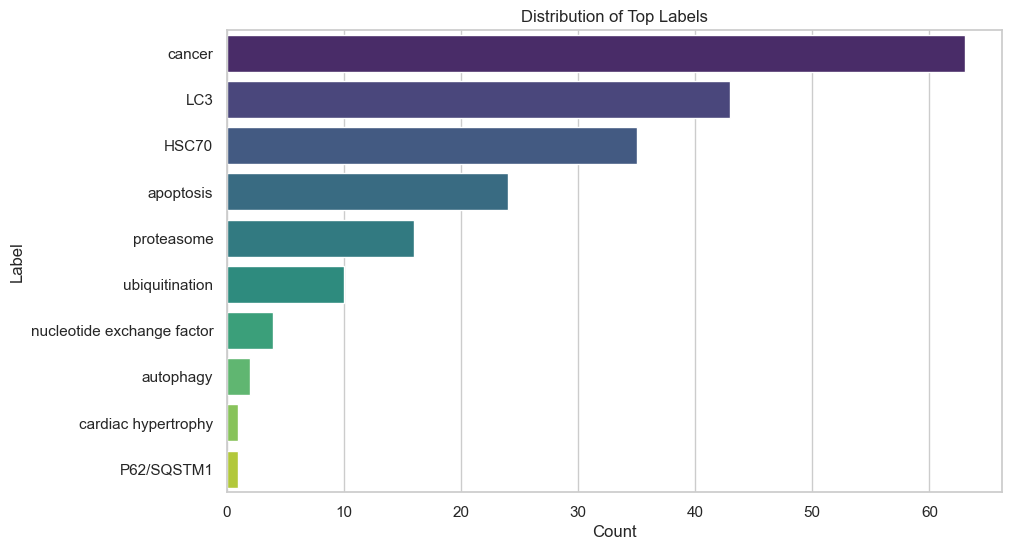

In [447]:
# extract the labels and scores from the DataFrame
results_df['Labels'] = results_df['Labels'].apply(lambda x: eval(x))
results_df['Scores'] = results_df['Scores'].apply(lambda x: eval(x))

# Extract the top label and score for each sentence
results_df['Top Label'] = results_df['Labels'].apply(lambda x: x[0])
results_df['Top Score'] = results_df['Scores'].apply(lambda x: x[0])

# plot the distribution of the top labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(y="Top Label", data=results_df, order=results_df['Top Label'].value_counts().index, palette='viridis')
plt.title("Distribution of Top Labels")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()



### Cancer was recognized most often followed by autophagy related LC3 and proteostasis related chaperon HSC70

In [448]:
results_df.head()

,Sentence,Labels,Scores,Top Label,Top Score
0,tumoreducated b cells selectively promote breast cancer lymph node metastasis by hspa4targeting igg primary tumors may create the premetastatic niche in secondary organs for subsequent metastasis humoral immunity contributes to the progression of certain cancers but the roles of b cells and their derived antibodies in premetastatic niche formation are poorly defined using a mouse model of spontaneous lymph node metastasis of breast cancer we show that primary tumors induced b cell accumulation in draining lymph nodes these b cells selectively promoted lymph node metastasis by producing pathogenic igg that targeted glycosylated membrane protein hspa4 and activated the hspa4binding protein itgb5 and the downstream srcnfb pathway in tumor cells for cxcr4sdf1axismediated metastasis high serum antihspa4 igg was correlated with high tumor hspa4 expression and poor prognosis of breast cancer subjects our findings identify a key role for tumoreducated b cells and their derived antibodies in lymph node premetastatic niche formation providing potential targets for cancer intervention,"[cancer, LC3, HSC70, P62/SQSTM1, proteasome, ubiquitination, nucleotide exchange factor, autophagy, apoptosis, cardiac hypertrophy]","[0.6762353181838989, 0.10858528316020966, 0.050915852189064026, 0.033793073147535324, 0.03292522951960564, 0.02974163554608822, 0.023961974307894707, 0.02216721512377262, 0.013303634710609913, 0.008370772935450077]",cancer,0.676235
1,hspa4 upregulation induces immune evasion via alkbh5cd58 axis in gastric cancer introduction gastric cancer gc is one of the leading causes of cancerrelated death worldwide recently targeted therapies including pd1 programmed cell death 1 antibodies have been used in advanced gc patients however identifying new biomarker for immunotherapy is still urgently needed the objective of this study is to unveil the immune evasion mechanism of gc cells and identify new biomarkers for immune checkpoint blockade therapy in patients with gc methods coimmunoprecipitation and merip were performed to investigate the mechanism of immune evasion of gc cells cocuture system was established to evaluate the cytotoxicity of cocultured cd8 t cells the clinical significance of hspa4 upregulation was analyzed by multiplex fluorescent immunohistochemistry staining in gc tumor tissues results histone acetylation causes hspa4 upregulation in gc tumor tissues hspa4 upregulation increases the protein stability of m6a demethylase alkbh5 alkbh5 decreases cd58 in gc cells through m6a methylation regulation the cytotoxicity of cd8 t cells are impaired and pd1pdl1 axis is activated when cd8 t cells are cocultured with hspa4 overexpressed gc cells hspa4 upregulation is associated with worse 5year overall survival of gc patients receiving only surgery it is an independent prognosis factor for worse survival of gc patients in gc patients receiving the combined chemotherapy with antipd1 immunotherapy hspa4 upregulation is observed in responders compared with nonresponders conclusion hspa4 upregulation causes the decrease of cd58 in gc cells via hspa4alkbh5cd58 axis followed by pd1pdl1 activation and impairment of cd8 t cells cytotoxicity finally induces immune evasion of gc cells hspa4 upregulation is associated with worse overall survival of gc patients with only surgery meanwhile hspa4 upregulation predicts for better response in gc patients receiving the combined immunotherapy,"[cancer, LC3, proteasome, P62/SQSTM1, nucleotide exchange factor, ubiquitination, autophagy, HSC70, apoptosis, cardiac hypertrophy]","[0.8288431763648987, 0.028598923236131668, 0.026072241365909576, 0.022245757281780243, 0.020209170877933502, 0.01953403279185295, 0.01899723708629608, 0.016946135088801384, 0.014060711488127708, 0.004492597654461861]",cancer,0.828843
2,hspa4 knockdown retarded progression and development of colorectal cancer purpose colorectal cancer crc is a common malignancy associated with hig

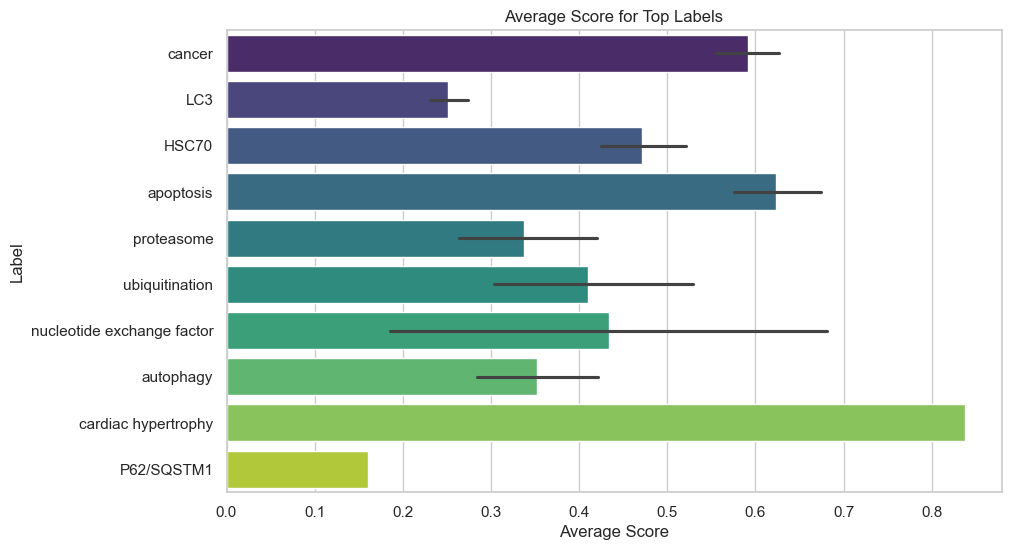

In [449]:
# plot the average score for each label
plt.figure(figsize=(10, 6))
sns.barplot(x="Top Score", y="Top Label", data=results_df, order=results_df['Top Label'].value_counts().index, palette='viridis')
plt.title("Average Score for Top Labels")
plt.xlabel("Average Score")
plt.ylabel("Label")
plt.show()


### Cardiac Hypertrophy shows high recognition even though the frequency was low

In [450]:
# Print the maximum score for each label
top_scores = results_df.groupby('Top Label')['Top Score'].max().sort_values(ascending=False)
print(top_scores)

Top Label
apoptosis                     0.840739
cardiac hypertrophy           0.837218
cancer                        0.830493
proteasome                    0.796586
ubiquitination                0.785451
HSC70                         0.780414
nucleotide exchange factor    0.736784
LC3                           0.442942
autophagy                     0.421015
P62/SQSTM1                    0.160425
Name: Top Score, dtype: float64


### If less relevant sequences are filtered out the sequences with high propability can be further analyzed

In [451]:
# Define a threshold for considering a sequence as important
threshold = 0.7

# make a new dataframe with the important sequences for each label
important_sequences_df = pd.DataFrame(columns=['Label','Top Score', 'Sequence'])

for label in candidate_labels:
    # Filter sequences with the current label
    label_sequences = results_df[results_df['Top Label'] == label]
    
    # Filter important sequences
    important_sequences = label_sequences[label_sequences['Top Score'] > threshold]
    
    # Create a temporary DataFrame for this label
    temp_df = pd.DataFrame({
        'Label': [label]*len(important_sequences),
        'Top Score': important_sequences['Top Score'].tolist(),
        'Sequence': important_sequences['Sentence'].tolist()
    })
    
    # Append the result to the important_sequences_df DataFrame
    important_sequences_df = pd.concat([important_sequences_df, temp_df], ignore_index=True)

important_sequences_df.head()

,Label,Top Score,Sequence
0,ubiquitination,0.785451,enteral glutamine infusion modulates ubiquitination of heat shock proteins grp75 and apg2 in the human duodenal mucosa glutamine the most abundant amino acid in the human body plays several important roles in the intestine previous studies showed that glutamine may affect protein expression by regulating ubiquitinproteasome system we thus aimed to evaluate the effects of glutamine on ubiquitinated proteins in human duodenal mucosa five healthy male volunteers were included and received during 5 h on two occasions and in a random order either an enteral infusion of maltodextrins alone 025 g kg1 h1 control mimicking carbohydratefed state or maltodextrins with glutamine 0117 g kg1 h1 glutamine endoscopic duodenal biopsies were then taken total cellular protein extracts were separated by 2d gel electrophoresis and analyzed by an immunodetection using antiubiquitin antibody differentially ubiquitinated proteins were then identified by liquid chromatographyelectrospray ionization msms five proteins were differentially ubiquitinated between control and glutamine conditions among these proteins we identified two chaperone proteins grp75 and hsp74 grp75 was less ubiquitinated after glutamine infusion compared with control in contrast hsp74 also called apg2 was more ubiquitinated after glutamine in conclusion we provide evidence that glutamine may regulate ubiquitination processes of specific proteins ie grp75 and apg2 grp75 has protective and antiinflammatory properties while apg2 indirectly regulates stressinduced cell survival and proliferation through interaction with zo1 further studies should confirm these results in stress conditions
1,HSC70,0.780414,sequence and expression analysis of hsp70 family genes in artemia franciscana thus far only one gene from the heat shock protein 70 hsp70 family has been identified in artemia franciscana here we used the draft artemia transcriptome database to search for other genes in the hsp70 family four novel hsp70 genes were identified and designated heat shock cognate 70 hsc70 heat shock 70 kda cognate 5 hsc705 immunoglobulin heavychain binding protein bip and hypoxia upregulated protein 1 hyou1 for each of these genes we obtained nucleotide and deduced amino acid sequences and reconstructed a phylogenetic tree expression analysis revealed that in the juvenile state the transcription of hsp70 and hsc70 was significantly p 005 induction gene expression analysis demonstrated that not all members of the hsp70 family are involved in the response to heat stress and selection and that especially altered expression of hsc70 plays a role in a population selected for increased thermotolerance
2,HSC70,0.765236,association of met439thr substitution in heat shock protein 70 gene with postoperative atrial fibrillation and serum hsp70 protein levels background atrial fibrillation af is a common arrhythmia encountered following cardiac surgery previously we have shown that higher expression of heat shock protein hsp 70 was associated with decreased incidence of postoperative af poaf suggestive of an antiarrhythmic role objective we have hypothesised that met493thr substitution of one of the important hsp70 genes may cause loss of these protective antiarrhythmic effects we therefore set out to examine the influence of hsp70 genotype on the incidence of poaf methods and results we prospectively recruited 244 caucasian patients undergoing elective coronary artery bypass surgery the median age was 65 years 4080 years poaf was defined as the characteristic arrhythmia lasting for at least 15 min occurring within first week following surgery and requiring treatment this occurred in 48 patients 197 validated met493thr substitution in hsp70hom was determined using established techniques of 244 patients genotype was determined for 242 cases the three genotypes mm mt and tt were present at frequencies of 066 031 and 003 respectively and were in hardyweinberg equilibri

## Entity recognition with medspacy to indetify key players

In [452]:
# Load the English language model for spaCy
nlp = medspacy.load('en_core_web_sm', disable=['parser'])

# Define a function to extract the entities from important sequences
def extract_entities(sequence):
    # Process the sequence with spaCy
    doc = nlp(sequence)
    
    # Extract entities
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    return entities

# Apply the function to each sequence
important_sequences_df['Entities'] = important_sequences_df['Sequence'].apply(extract_entities)

important_sequences_df.head()


,Label,Top Score,Sequence,Entities
0,ubiquitination,0.785451,enteral glutamine infusion modulates ubiquitination of heat shock proteins grp75 and apg2 in the human duodenal mucosa glutamine the most abundant amino acid in the human body plays several important roles in the intestine previous studies showed that glutamine may affect protein expression by regulating ubiquitinproteasome system we thus aimed to evaluate the effects of glutamine on ubiquitinated proteins in human duodenal mucosa five healthy male volunteers were included and received during 5 h on two occasions and in a random order either an enteral infusion of maltodextrins alone 025 g kg1 h1 control mimicking carbohydratefed state or maltodextrins with glutamine 0117 g kg1 h1 glutamine endoscopic duodenal biopsies were then taken total cellular protein extracts were separated by 2d gel electrophoresis and analyzed by an immunodetection using antiubiquitin antibody differentially ubiquitinated proteins were then identified by liquid chromatographyelectrospray ionization msms five proteins were differentially ubiquitinated between control and glutamine conditions among these proteins we identified two chaperone proteins grp75 and hsp74 grp75 was less ubiquitinated after glutamine infusion compared with control in contrast hsp74 also called apg2 was more ubiquitinated after glutamine in conclusion we provide evidence that glutamine may regulate ubiquitination processes of specific proteins ie grp75 and apg2 grp75 has protective and antiinflammatory properties while apg2 indirectly regulates stressinduced cell survival and proliferation through interaction with zo1 further studies should confirm these results in stress conditions,"[(apg2, ORG), (five, CARDINAL), (5, CARDINAL), (two, CARDINAL), (025, CARDINAL), (2d, CARDINAL), (five, CARDINAL), (two, CARDINAL), (hsp74 grp75, PERSON), (apg2, ORG), (ie grp75, PERSON), (apg2, ORG), (apg2, ORG), (zo1, PERSON)]"
1,HSC70,0.780414,sequence and expression analysis of hsp70 family genes in artemia franciscana thus far only one gene from the heat shock protein 70 hsp70 family has been identified in artemia franciscana here we used the draft artemia transcriptome database to search for other genes in the hsp70 family four novel hsp70 genes were identified and designated heat shock cognate 70 hsc70 heat shock 70 kda cognate 5 hsc705 immunoglobulin heavychain binding protein bip and hypoxia upregulated protein 1 hyou1 for each of these genes we obtained nucleotide and deduced amino acid sequences and reconstructed a phylogenetic tree expression analysis revealed that in the juvenile state the transcription of hsp70 and hsc70 was significantly p 005 induction gene expression analysis demonstrated that not all members of the hsp70 family are involved in the response to heat stress and selection and that especially altered expression of hsc70 plays a role in a population selected for increased thermotolerance,"[(70, CARDINAL), (four, CARDINAL), (70, CARDINAL), (70 kda, QUANTITY), (5, CARDINAL), (1, CARDINAL), (transcription, CARDINAL)]"
2,HSC70,0.765236,association of met439thr substitution in heat shock protein 70 gene with postoperative atrial fibrillation and serum hsp70 protein levels background atrial fibrillation af is a common arrhythmia encountered following cardiac surgery previously we have shown that higher expression of heat shock protein hsp 70 was associated with decreased incidence of postoperative af poaf suggestive of an antiarrhythmic role objective we have hypothesised that met493thr substitution of one of the important hsp70 genes may cause loss of these protective antiarrhythmic effects we therefore set out to examine the influence of hsp70 genotype on the incidence of poaf methods and results we prospectively recruited 244 caucasian patients undergoing elective coronary artery bypass surgery the median age was 65 years 4080 years poaf was defined as the characteristic arrhythmia lasting for at least 15 min occu

### cleaning the entity list to identify names of genes

In [456]:
# clean the entities by removing certain types like numbers, dates, etc.
def clean_entities(entities):
    cleaned_entities = []
    for entity, label in entities:
        if label not in ['CARDINAL', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY']:
            cleaned_entities.append((entity, label)) 
    return cleaned_entities

# Apply the clean_entities function to the 'Entities' column and concatenate the results into a single list
important_sequences_df['Cleaned Entities'] = important_sequences_df['Entities'].apply(clean_entities)

important_sequences_df.head()


,Label,Top Score,Sequence,Entities,Cleaned Entities
0,ubiquitination,0.785451,enteral glutamine infusion modulates ubiquitination of heat shock proteins grp75 and apg2 in the human duodenal mucosa glutamine the most abundant amino acid in the human body plays several important roles in the intestine previous studies showed that glutamine may affect protein expression by regulating ubiquitinproteasome system we thus aimed to evaluate the effects of glutamine on ubiquitinated proteins in human duodenal mucosa five healthy male volunteers were included and received during 5 h on two occasions and in a random order either an enteral infusion of maltodextrins alone 025 g kg1 h1 control mimicking carbohydratefed state or maltodextrins with glutamine 0117 g kg1 h1 glutamine endoscopic duodenal biopsies were then taken total cellular protein extracts were separated by 2d gel electrophoresis and analyzed by an immunodetection using antiubiquitin antibody differentially ubiquitinated proteins were then identified by liquid chromatographyelectrospray ionization msms five proteins were differentially ubiquitinated between control and glutamine conditions among these proteins we identified two chaperone proteins grp75 and hsp74 grp75 was less ubiquitinated after glutamine infusion compared with control in contrast hsp74 also called apg2 was more ubiquitinated after glutamine in conclusion we provide evidence that glutamine may regulate ubiquitination processes of specific proteins ie grp75 and apg2 grp75 has protective and antiinflammatory properties while apg2 indirectly regulates stressinduced cell survival and proliferation through interaction with zo1 further studies should confirm these results in stress conditions,"[(apg2, ORG), (five, CARDINAL), (5, CARDINAL), (two, CARDINAL), (025, CARDINAL), (2d, CARDINAL), (five, CARDINAL), (two, CARDINAL), (hsp74 grp75, PERSON), (apg2, ORG), (ie grp75, PERSON), (apg2, ORG), (apg2, ORG), (zo1, PERSON)]","[(apg2, ORG), (hsp74 grp75, PERSON), (apg2, ORG), (ie grp75, PERSON), (apg2, ORG), (apg2, ORG), (zo1, PERSON)]"
1,HSC70,0.780414,sequence and expression analysis of hsp70 family genes in artemia franciscana thus far only one gene from the heat shock protein 70 hsp70 family has been identified in artemia franciscana here we used the draft artemia transcriptome database to search for other genes in the hsp70 family four novel hsp70 genes were identified and designated heat shock cognate 70 hsc70 heat shock 70 kda cognate 5 hsc705 immunoglobulin heavychain binding protein bip and hypoxia upregulated protein 1 hyou1 for each of these genes we obtained nucleotide and deduced amino acid sequences and reconstructed a phylogenetic tree expression analysis revealed that in the juvenile state the transcription of hsp70 and hsc70 was significantly p 005 induction gene expression analysis demonstrated that not all members of the hsp70 family are involved in the response to heat stress and selection and that especially altered expression of hsc70 plays a role in a population selected for increased thermotolerance,"[(70, CARDINAL), (four, CARDINAL), (70, CARDINAL), (70 kda, QUANTITY), (5, CARDINAL), (1, CARDINAL), (transcription, CARDINAL)]",[]
2,HSC70,0.765236,association of met439thr substitution in heat shock protein 70 gene with postoperative atrial fibrillation and serum hsp70 protein levels background atrial fibrillation af is a common arrhythmia encountered following cardiac surgery previously we have shown that higher expression of heat shock protein hsp 70 was associated with decreased incidence of postoperative af poaf suggestive of an antiarrhythmic role objective we have hypothesised that met493thr substitution of one of the important hsp70 genes may cause loss of these protective antiarrhythmic effects we therefore set out to examine the influence of hsp70 genotype on the incidence of poaf methods and results we prospectively recruited 244 caucasian patients undergoing elective coronary artery byp

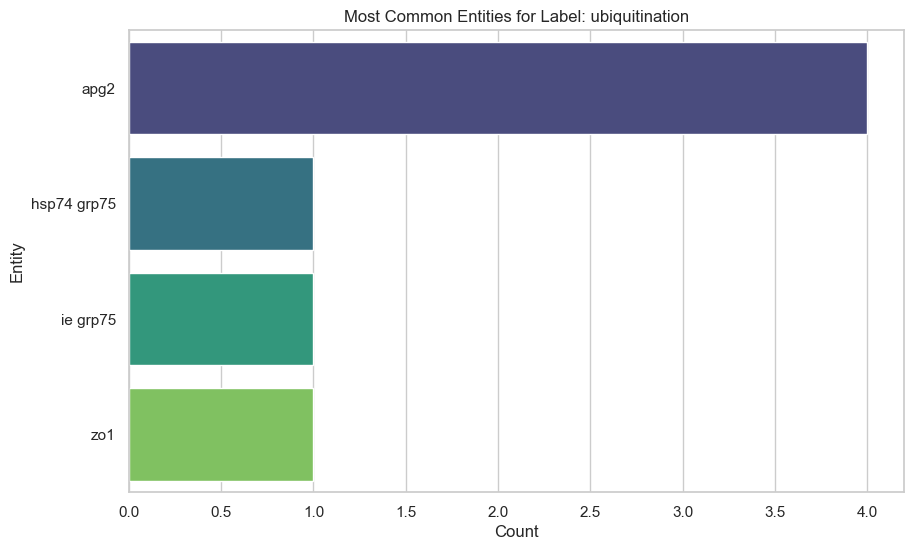

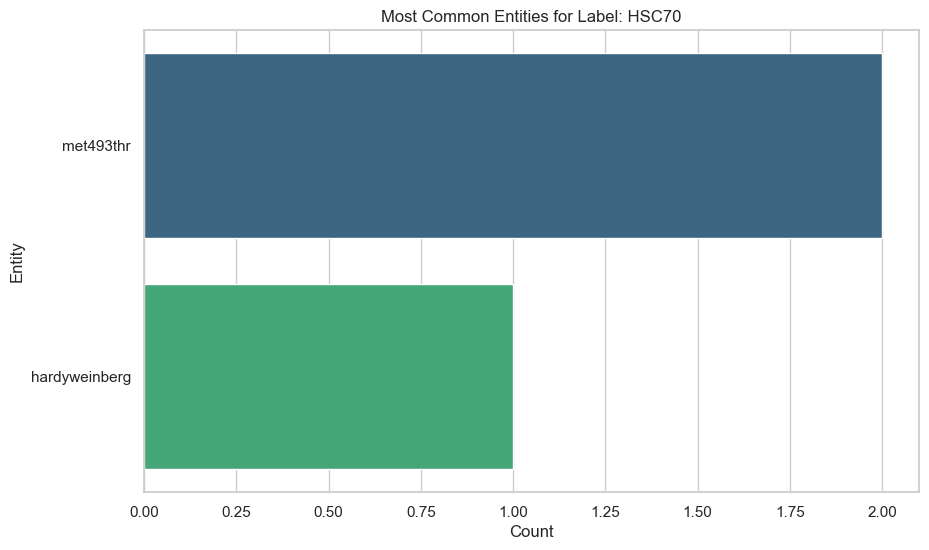

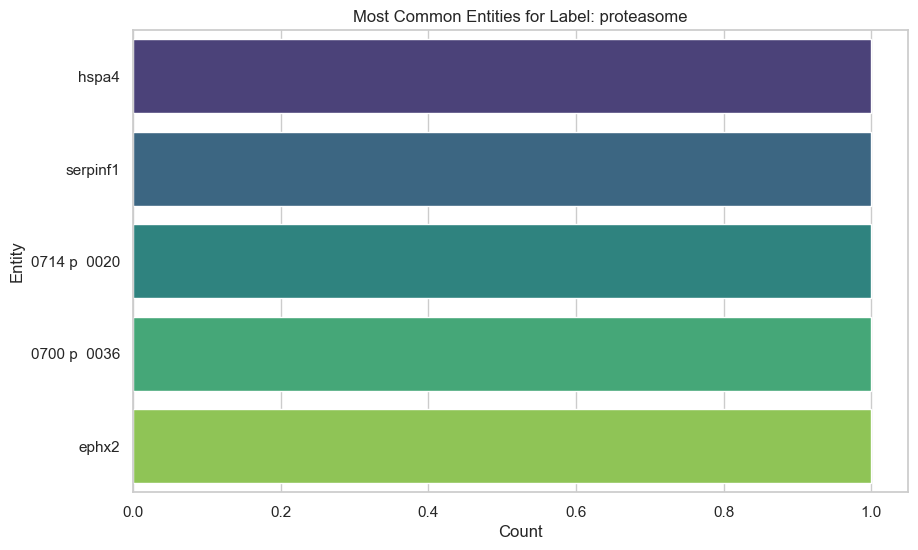

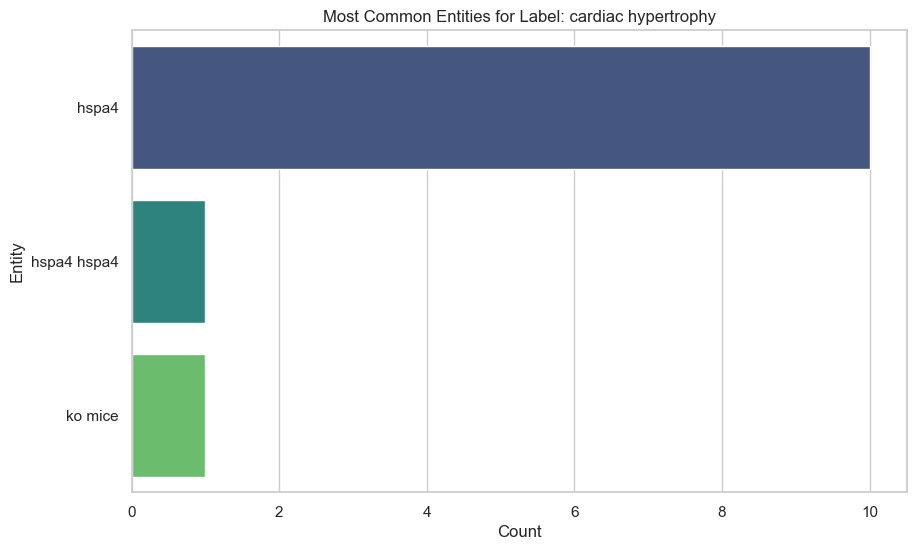

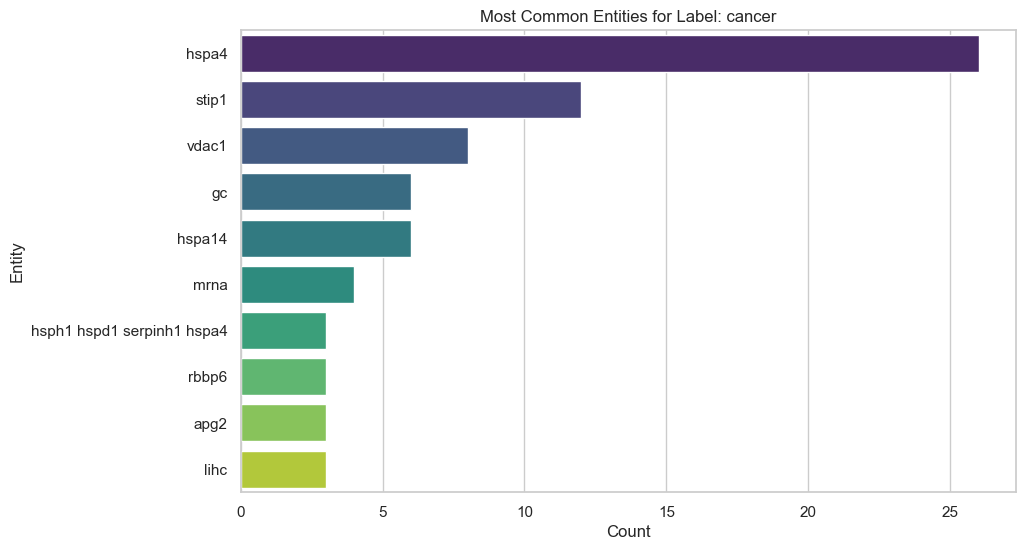

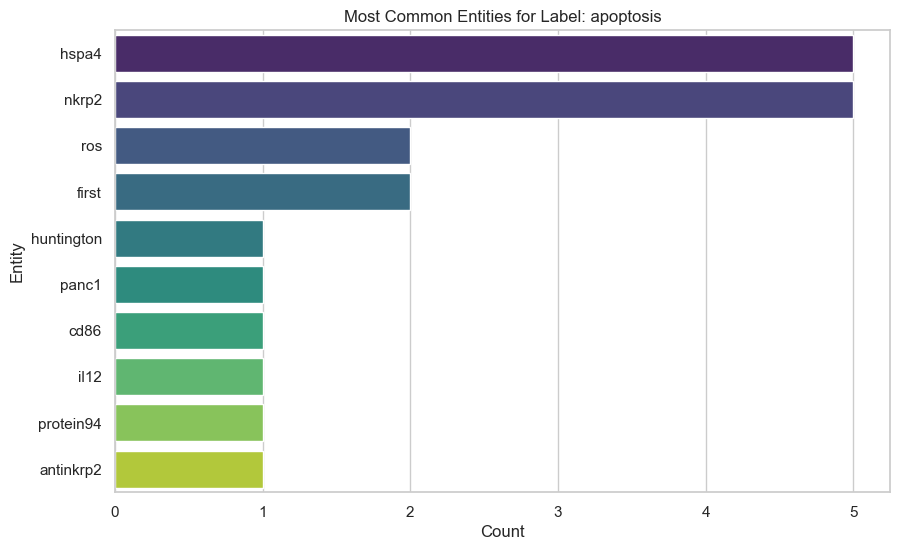

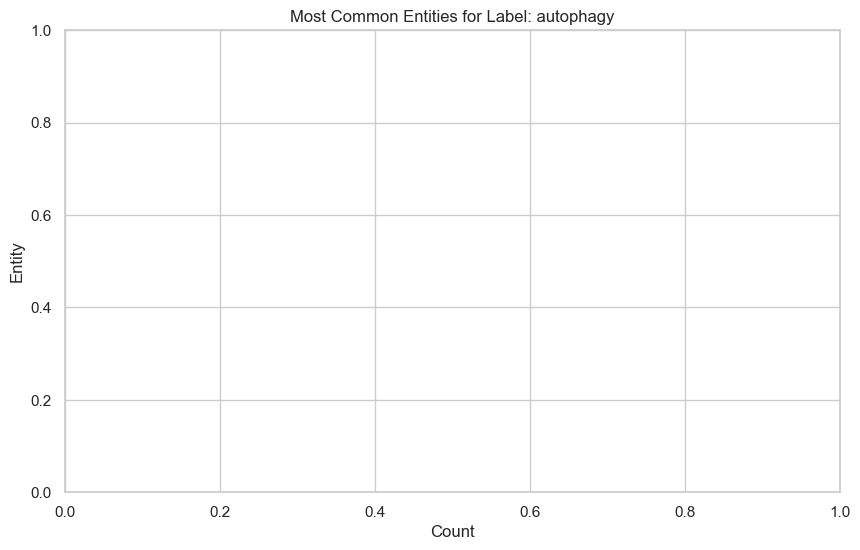

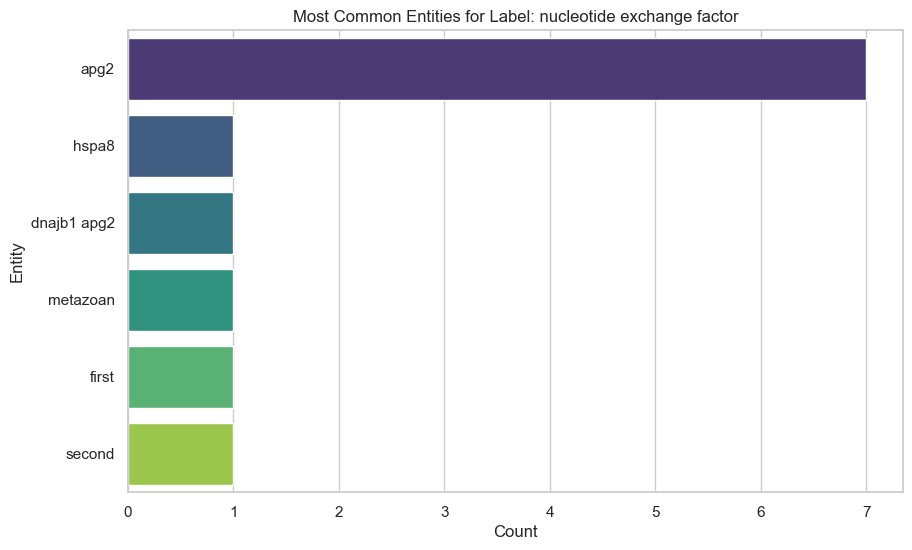

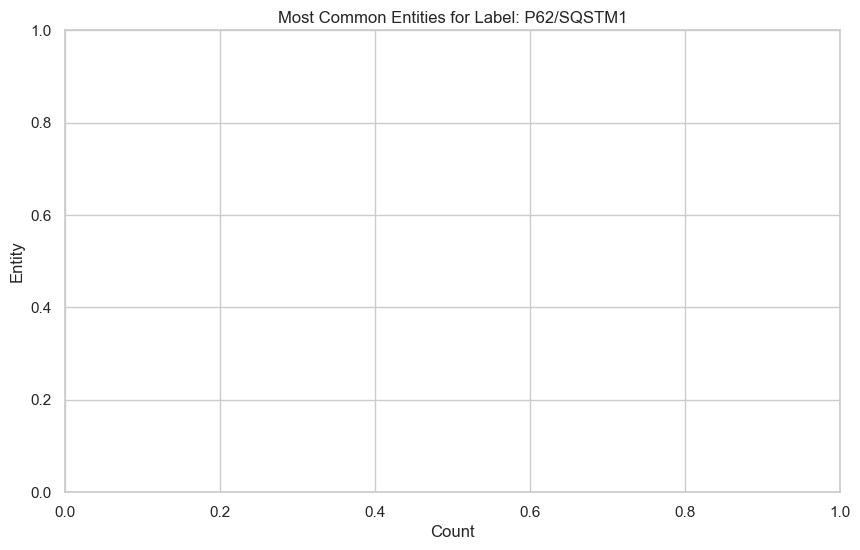

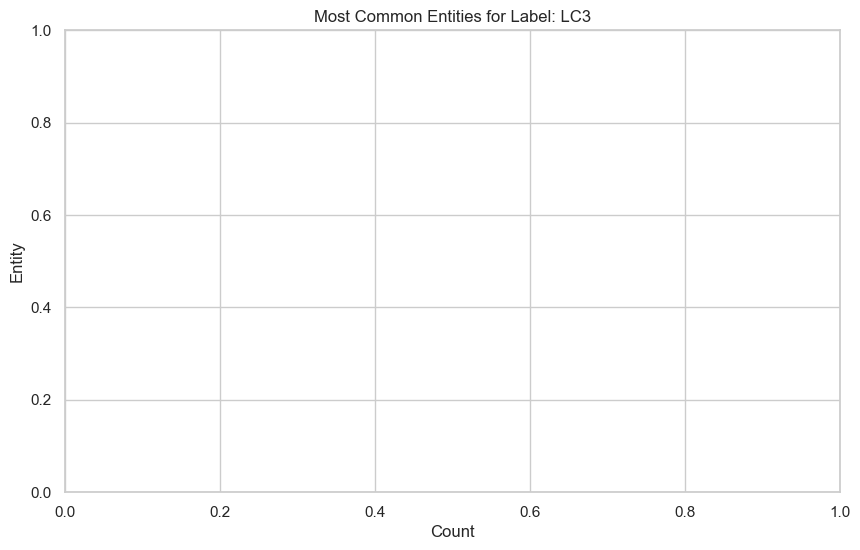

In [467]:
# Plot the most common entities for each label
for label in candidate_labels:

    # Filter sequences with the current label
    label_sequences = important_sequences_df[important_sequences_df['Label'] == label]
    
    # Extract entities, skipping empty dictionaries
    entities = [ent for ents in label_sequences['Cleaned Entities'] if ents for ent in ents]
    
    # Create a DataFrame
    entities_df = pd.DataFrame(entities, columns=['Entity', 'Label'])
    
    # Plot the most common entities
    plt.figure(figsize=(10, 6))
    sns.countplot(y="Entity", data=entities_df, order=entities_df['Entity'].value_counts().head(10).index, palette='viridis')
    plt.title(f"Most Common Entities for Label: {label}")
    plt.xlabel("Count")
    plt.ylabel("Entity")
    plt.show()

## The most frequent entities that are genes can be further researched and their role in the process analysed

In [478]:
# save entities_df with the current time stamp
filename = f"important_entities_hspa4_{current_time}.csv"
entities_df.to_csv(filename, index=False)